# Content Based Filtering 

This notebook looks at what content based filtering is and how we can apply it to build a recommender system in Python. We start by detailing what content based filtering is. We also look at the advantages adn disadvantages of the method. We also compare this approach with the other popular recommender system method - collaborative filtering. 

> content-based recommendation systems work by suggesting items to users based on what they have liked in the past

# Overview

Content-based recommendation systems are algorithms that **recommend items to users based on their past interactions with items**, such as viewing history, purchasing history, or rating history. These systems **use the content or attributes of items**, such as genre, director, actor, or tags, to recommend items that are similar to those the user has previously interacted with.

Another way of thinking about content based systems: the system uses item **metadata** (attributes) such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it. And to recommend that, it will make use of the user's past item metadata. 
- A good example could be YouTube, where based on your history, it suggests you new videos that you could potentially watch.


## Disadvantages

- They can suffer from limited diversity in recommendations, as they only consider the items that the user has interacted with in the past.
- They may not be able to recommend items that are outside of the user's normal preferences.
- Suffer from *cold start problem*

> Note, that to alleviate cold start problem we can employ **Active learning**. This technique is used in recommendation systems to address the "cold-start" problem, where there is little to no data available about a new user's preferences. The basic idea behind active learning is to interact with the user and **collect their preferences or feedback** to build a better model of their interests.

## Versus Collaborative Filtering

Content-based recommendation systems are different from collaborative filtering systems, which make recommendations based on the past behavior of similar users. In contrast, content-based systems only consider the user's individual preferences, not the preferences of other users.


# Data

The dataset files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. This dataset captures feature points like cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, IMDb vote counts, and vote averages. Note we are dealing with a subset of the data. 

- The Full MovieLens Dataset comprises of 26 million ratings and 750,000 tag applications, from 270,000 users on all the 45,000 movies in this dataset. It can be accessed from the official [GroupLens](https://grouplens.org/datasets/movielens/latest/) website.

In [96]:
# get modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.style as style
import matplotlib.cm as cm

%matplotlib inline



In [66]:
# Load Movies Metadata
metadata = pd.read_csv('Data/movies_metadata.csv', low_memory=False)

# Keep specific columns
metadata = metadata[['original_title', 'production_companies', 'genres', 'runtime', 'vote_average', 'vote_count', 'original_language']]
metadata = metadata[metadata.original_language == 'en'].drop(['original_language'], axis=1)

# Print the first 5 rows
display(metadata.head(5))
print("Shape of Data:", metadata.shape)

,original_title,production_companies,genres,runtime,vote_average,vote_count
0,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",81.0,7.7,5415.0
1,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",104.0,6.9,2413.0
2,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",101.0,6.5,92.0
3,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",127.0,6.1,34.0
4,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'id': 35, 'name': 'Comedy'}]",106.0,5.7,173.0


Shape of Data: (32269, 6)


# Exploration of Data

Specifically what we shall look at is the top rated movies, movies with most votes and best movies in each genre or by each production company.

In [67]:
metadata[['vote_average', 'vote_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
vote_average,32267.0,5.491171,1.941068,0.0,5.0,5.9,6.7,10.0
vote_count,32267.0,141.566430,574.585080,0.0,3.0,10.0,43.0,14075.0


In [68]:
# Which data has NA for specific columns
metadata[metadata.vote_average.isna()]

# Remove this data
metadata = metadata.drop(metadata[metadata.vote_average.isna()].index)


In [69]:
#metadata[metadata.vote_count>2000].vote_count.plot(kind='hist')
len(metadata[metadata.vote_count>=5000])

100

In [70]:
# ranked top to bottom rated movies
metadata.sort_values(['vote_average'], ascending=False)


# top movies with over 5000 votes
metadata[metadata.vote_count>5000].sort_values(['vote_average'], ascending=False)


,original_title,production_companies,genres,runtime,vote_average,vote_count
314,The Shawshank Redemption,"[{'name': 'Castle Rock Entertainment', 'id': 9...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",142.0,8.5,8358.0
834,The Godfather,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",175.0,8.5,6024.0
2843,Fight Club,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 18, 'name': 'Drama'}]",139.0,8.3,9678.0
292,Pulp Fiction,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",154.0,8.3,8670.0
12481,The Dark Knight,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",152.0,8.3,12269.0
...,...,...,...,...,...,...
17124,Pirates of the Caribbean: On Stranger Tides,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",136.0,6.4,5068.0
23358,Lucy,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",89.0,6.3,6048.0
18995,Prometheus,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",124.0,6.3,5152.0
30543,Suicide Squad,"[{'name': 'DC Comics', 'id': 429}, {'name': 'D...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",123.0,5.9,7717.0


In [103]:
sample4

,original_title,production_companies,genres,runtime,vote_average,vote_count
314,The Shawshank Redemption,"[{'name': 'Castle Rock Entertainment', 'id': 9...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",142.0,8.5,8358.0
834,The Godfather,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",175.0,8.5,6024.0
2843,Fight Club,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 18, 'name': 'Drama'}]",139.0,8.3,9678.0
292,Pulp Fiction,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",154.0,8.3,8670.0
12481,The Dark Knight,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",152.0,8.3,12269.0
351,Forrest Gump,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",142.0,8.2,8147.0
1154,The Empire Strikes Back,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",124.0,8.2,5998.0
15480,Inception,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",148.0,8.1,14075.0
256,Star Wars,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",121.0,8.1,6778.0
22879,Interstellar,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",169.0,8.1,11187.0


In [108]:
for i, title in enumerate(sample4.original_title):
    print(i)
    print(title)

0
The Shawshank Redemption
1
The Godfather
2
Fight Club
3
Pulp Fiction
4
The Dark Knight
5
Forrest Gump
6
The Empire Strikes Back
7
Inception
8
Star Wars
9
Interstellar


In [112]:
sample4.loc[sample4.original_title=="The Shawshank Redemption", "vote_count"]

KeyError: 'The Shawshank Redemption'

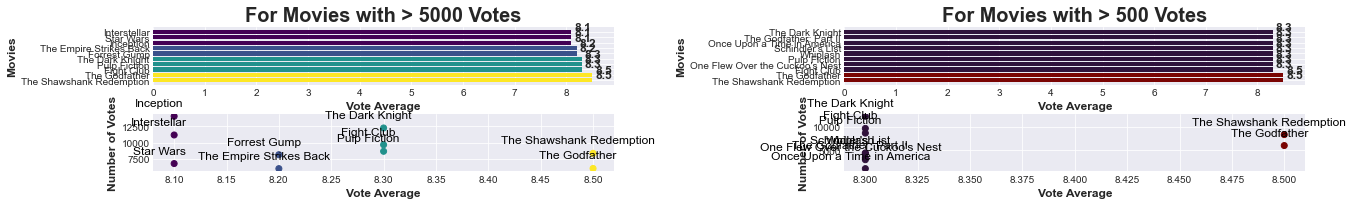

In [143]:
# Horizontal Bar Charts (Top Rated Movies)
sample2 = metadata[metadata.vote_count>=500] \
    .sort_values(['vote_average'], ascending=False) \
    .head(10)
sample4 = metadata[metadata.vote_count>=5000] \
    .sort_values(['vote_average'], ascending=False) \
    .head(10)

# Use a stylesheet
style.use('seaborn-darkgrid')


# color scheme for Sample 4
vote_min = sample4.vote_average.min() # get range of votes
vote_max = sample4.vote_average.max()
vote_norm = (sample4.vote_average - vote_min) / (vote_max - vote_min) # Normalize 
colors = cm.viridis(vote_norm) # Use a colormap to map vote average

# color scheme for Sample 2
vote_min = sample2.vote_average.min() # get range of votes
vote_max = sample2.vote_average.max()
vote_norm = (sample2.vote_average - vote_min) / (vote_max - vote_min) # Normalize 
colors2 = cm.turbo(vote_norm) # Use a colormap to map vote average

# create figure
fig = plt.figure(figsize=(20, 20))


# Plot the bar plot -- 1
plt.subplot(2, 2, 1)
bar = plt.barh(y=sample4.original_title, width=sample4.vote_average, color=colors)
plt.title("For Movies with > 5000 Votes", fontsize=20, fontweight='bold')
plt.xlabel("Vote Average", fontsize=12, fontweight='semibold')
plt.ylabel("Movies", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 7), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)


# Plot the scatter plot -- 2
plt.subplot(2, 2, 3)
plt.scatter(sample4.vote_average, sample4.vote_count, c=colors, cmap='viridis')
plt.xlabel('Vote Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Votes', fontsize=12, fontweight='semibold')
for i, title in enumerate(sample4.original_title):
    plt.annotate(title, (sample4.loc[sample4.original_title==title, "vote_average"], sample4.loc[sample4.original_title==title, "vote_count"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')

# Plot the bar plot -- 3
plt.subplot(2, 2, 2)
bar = plt.barh(y=sample2.original_title, width=sample2.vote_average, color=colors2)
plt.title("For Movies with > 500 Votes", fontsize=20, fontweight='bold')
plt.xlabel("Vote Average", fontsize=12, fontweight='semibold')
plt.ylabel("Movies", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 7), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot the bar plot -- 4
plt.subplot(2, 2, 4)
plt.scatter(sample2.vote_average, sample2.vote_count, c=colors2, cmap='autumn')
plt.xlabel('Vote Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Votes', fontsize=12, fontweight='semibold')
for i, title in enumerate(sample2.original_title):
    plt.annotate(title, (sample2.loc[sample2.original_title==title, "vote_average"], sample2.loc[sample2.original_title==title, "vote_count"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')


fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)


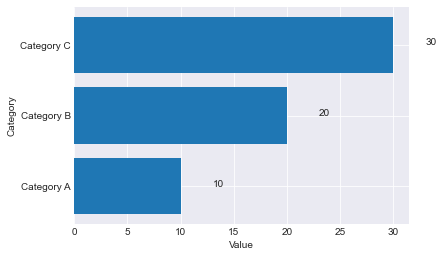

In [83]:
import matplotlib.pyplot as plt

# Define the data to be plotted
categories = ['Category A', 'Category B', 'Category C']
values = [10, 20, 30]

# Create the horizontal bar chart
plt.barh(categories, values)

# Add labels to the x and y axes
plt.xlabel('Value')
plt.ylabel('Category')

# Add annotations to the bars
for i, v in enumerate(values):
    plt.text(v + 3, i, str(v))

# Show the plot
plt.show()


# A Simple Recommender System

These type of recommenders have no intrinsic algorithm that generates personalized recommendations. Instead it offers generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. 


## Example 

We want to clone the IMDb top 250 and use it as a simple recommendation to users. 

The following are the steps involved:

1. Decide on the metric or score to rate movies on.
2. Calculate the score for every movie.
3. Sort the movies based on the score and output the top results.

Note that we are to come up with a weighted rating that takes into account the average rating and the number of votes it has accumulated. Such a system will make sure that a movie with a 9 rating from 100,000 voters gets a (far) higher score than a movie with the same rating but a mere few hundred voters.

Since we are trying to build a clone of IMDB's Top 250, let's use its weighted rating formula as a metric/score. 

Mathematically, it is represented as follows: $\begin{equation} \text{Weighted Rating }(\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right) \end{equation}$

In the above equation,

- $v$ is the number of votes for the movie;

- $m$ is the minimum votes required to be listed in the chart;

- $R$ is the average rating of the movie;

- $C$ is the mean vote across the whole report.
 
 We already have $v$ (**vote_count**) and $R$ (**vote_average**) in the data set for each movie. Determining an appropriate value for $m$ is a hyperparameter that you can choose accordingly since there is no right value for $m$. We shall use cuttoff $m$ as the 90th percentile. In other words, for a movie to be featured in the charts, it must have **more votes** than at least 90% of the movies on the list. *Note, as percentile decreases, the number of movies considered will increase*. 

In [12]:
metadata

,budget,genres,id,imdb_id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,tt6209470,fa,رگ خواب,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,Subdue,4.0,1.0
45462,0,"[{'id': 18, 'name': 'Drama'}]",111109,tt2028550,tl,Siglo ng Pagluluwal,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,Century of Birthing,9.0,3.0
45463,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,tt0303758,en,Betrayal,0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,Betrayal,3.8,6.0
45464,0,[],227506,tt0008536,en,Satana likuyushchiy,0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,Satan Triumphant,0.0,0.0


In [ ]:
# Calculate C (mean votes)

C = metadata['vote_average'].mean()
print(C)

